# 1.0 Setup

## 1.1 Package Imports

In [1]:
import geopandas as gpd
import pandas as pd
import time
from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## 1.2 Data Import

In [2]:
# Setting the file path
path = '../Data/Data_pt1/'

In [3]:
# Reading in the data as a Pandas DataFrame
#REMINDER - The listings data must be downloaded from Inside Airbnb
listings = pd.read_csv(path + 'NY_Airbnb_Oct_2023/listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

# Printing the shape of the DataFrame
listings_gpdf.shape

(38792, 76)

In [4]:
# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough
boroughs = gpd.read_file(path + "NYC Boroughs/nybb_22a/nybb.shp")

boroughs = boroughs.to_crs('EPSG:4326')
manhattan = boroughs[boroughs['BoroName']=='Manhattan']

# get the start time
st = time.time()

listings_mask = listings_gpdf.within(manhattan.loc[3, 'geometry'])

listings_manhattan = listings_gpdf.loc[listings_mask]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 32.23067283630371 seconds


In [7]:
listings_manhattan.shape

(16904, 76)

# 2.0 Spatial Indexing

## 2.1 R-Tree

In [8]:
geometry = manhattan.loc[3, 'geometry']

In [9]:
geometry.bounds

(-74.04772947917839, 40.68291657291054, -73.90665087606901, 40.87903763229265)

In [10]:
# Building the R-tree spatial index
sindex = listings_gpdf.sindex

# get the start time
st = time.time()

# Getting the indexes of the possible matches from the R-tree
idex_possible_matches = list(sindex.intersection(geometry.bounds))

# subsetting the dataframe to be only possible matches
possible_matches_df = listings_gpdf.iloc[idex_possible_matches]

# Performing an intersection to get the precise matches
precise_matches_df = possible_matches_df[possible_matches_df.intersects(geometry)]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 31.91537618637085 seconds


In [11]:
precise_matches_df.shape

(16904, 76)

### 2.1.1 R-Tree with Subdivided Polygons

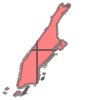

In [12]:
# Create the subdivided polygons
subdivided_polygon = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=1) # quadrant_width is in the CRS measurement units (4326:degrees)
subdivided_polygon

In [13]:
# get the start time
st = time.time()

points_in_geometry = pd.DataFrame()
for geom in subdivided_polygon.geoms:
    # add in a slight buffer to account for points falling on the lines of the subdivided polygons
    geom = geom.buffer(1e-14).buffer(0)

    # Getting the indexes of the possible matches from the R-tree
    idex_possible_matches = list(sindex.intersection(geom.bounds))
    possible_matches_df = listings_gpdf.iloc[idex_possible_matches]
    
    # Performing an intersection to get the precise matches
    precise_matches_df = possible_matches_df[possible_matches_df.intersects(geom)]
    #points_in_geometry = points_in_geometry.append(precise_matches_df)
    points_in_geometry = pd.concat([points_in_geometry, precise_matches_df], ignore_index=True)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 7.570502996444702 seconds


In [14]:
points_in_geometry.shape

(16904, 76)

## 2.2 H3

In [15]:
# Reference Materials
# https://www.uber.com/blog/h3/
# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

In [16]:
%matplotlib inline 
from h3 import h3
import contextily

In [17]:
# Set the H3 resolution
h3_resolution = 8
 
# Creating a function to add the H3 identifier to each of the Airbnb Points
def add_h3_id(row):
    return h3.geo_to_h3(
      row.geometry.y, row.geometry.x, h3_resolution)

# Executing the function
listings_manhattan['h3'] = listings_gpdf.apply(add_h3_id, axis=1)

# Display the dataframe
listings_manhattan.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,h3
1,3533741,https://www.airbnb.com/rooms/3533741,20231001204715,2023-10-02,previous scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,Come stay in the heart of historic Hells Kitch...,NaN,https://a0.muscache.com/pictures/45157664/862a...,17791294,...,NaN,NaN,f,1,0,1,0,NaN,POINT (-73.98719 40.76878),882a1008b3fffff
5,53903662,https://www.airbnb.com/rooms/53903662,20231001204715,2023-10-02,city scrape,Condo in New York · ★4.43 · 1 bedroom · 1 bed ...,"This room is in a full floor, 4 bedroom apartm...",The East Village is located in Downtown Manhat...,https://a0.muscache.com/pictures/61ebc358-7be7...,74338125,...,4.44,NaN,t,2,0,2,0,2.86,POINT (-73.98691 40.72625),882a100d35fffff
6,53722728,https://www.airbnb.com/rooms/53722728,20231001204715,2023-10-02,city scrape,Condo in New York · ★4.29 · 1 bedroom · 1 bed ...,"This room is in a full floor, 4 bedroom apartm...",The East Village is located in Downtown Manhat...,https://a0.muscache.com/pictures/6633c373-1642...,74338125,...,4.15,NaN,f,2,0,2,0,1.88,POINT (-73.98801 40.72813),882a1072c9fffff
8,3539618,https://www.airbnb.com/rooms/3539618,20231001204715,2023-10-02,previous scrape,Rental unit in New York · ★4.67 · Studio · 1 b...,This is a large alcove studio in a new buildin...,NaN,https://a0.muscache.com/pictures/44646761/af5f...,506909,...,4.88,NaN,f,1,1,0,0,0.08,POINT (-73.98032 40.73779),882a100d2bfffff
10,675959117355164668,https://www.airbnb.com/rooms/675959117355164668,20231001204715,2023-10-02,city scrape,Rental unit in New York · 1 bedroom · 1 bed · ...,Enjoy convenience in this centrally-located He...,Convenient and filled with food options and co...,https://a0.muscache.com/pictures/d969a120-e590...,1863597,...,NaN,NaN,f,1,0,1,0,NaN,POINT (-73.98681 40.76539),882a100d65fffff


In [18]:
# Creating a dataframe with the count of airbnb's within each hexagon
airbnb_count = listings_manhattan.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()

In [19]:
# Defining a function to get the geometry for each of the H3 hexagons
def add_h3_geometry(row):
    points = h3.h3_to_geo_boundary(
      row['h3'], True)
    return Polygon(points)

# Adding the geometry to the airbnb_count dataframe
airbnb_count['geometry'] = airbnb_count.apply(add_h3_geometry, axis=1)

# Converting to a geodataframe
gdf = gpd.GeoDataFrame(airbnb_count, crs='EPSG:4326')

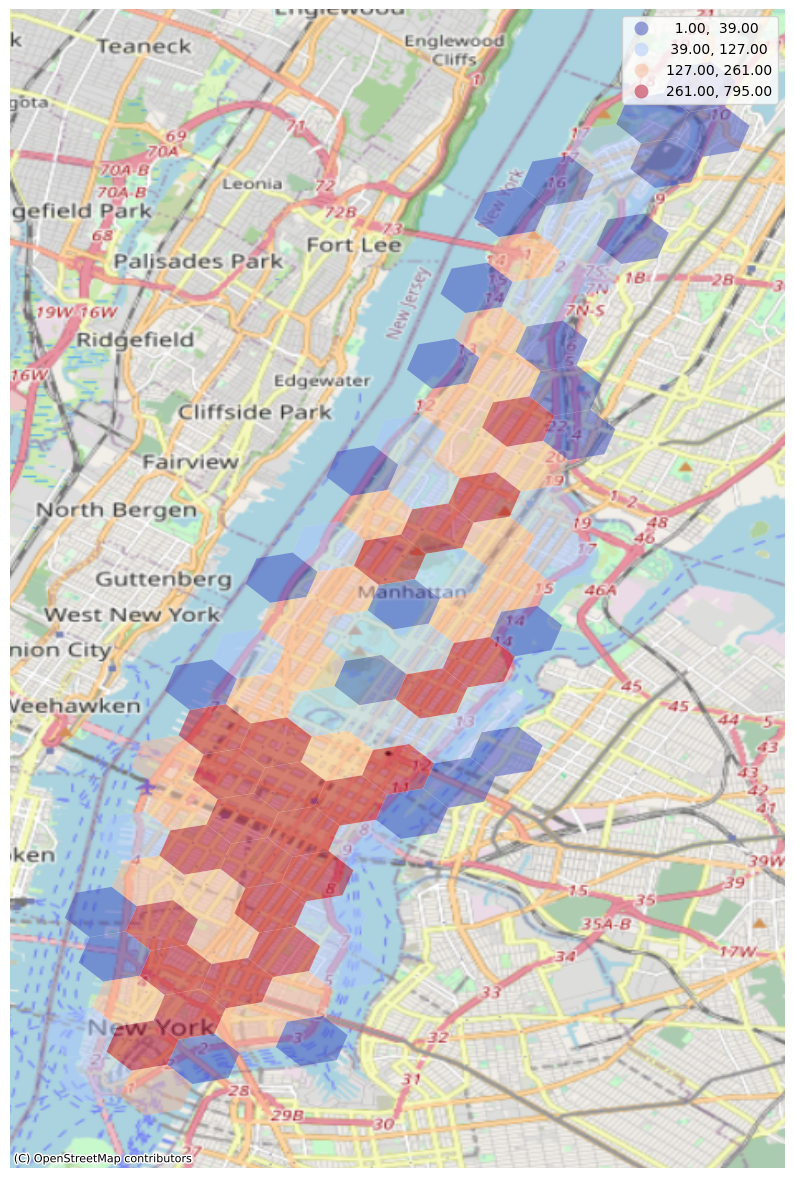

In [20]:
# Plotting a choropleth map of the Airbnb's within each cell
f, ax = plt.subplots(1, figsize=(10, 20))
   
# Plot choropleth of counts
gdf.plot(
    column='count', 
    cmap='coolwarm', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.5,
    legend=True,
    ax=ax
)

# Add basemap
contextily.add_basemap(
    ax,
    crs=gdf.crs,
    #source=contextily.providers.Stamen.TonerLite,
    source=contextily.providers.OpenStreetMap.Mapnik,
)
    
# Remove axis
ax.set_axis_off()

# Display
plt.show()
#f.savefig(path + r"Neighborhood Residuals.png")